In [ ]:
# %% 
"""
Note: I need to import the data from parameters.py
"""
import geopandas as gpd
import numpy as np
import pandas as pd
import itertools
import pyomo.environ as pyo
import matplotlib.pyplot as plt
from parameters_dynamic2 import dps, hfs, hps, hcs, services, health_workers, levels, HFs_to_locate, distance_matrix, workers_to_allocate, lb_workers, a_HF, a_W, t1max, service_time, working_hours
from parameters_dynamic2 import demand_points_gdf, hfs_gdf, hcs_gdf, hps_gdf
from parameters_dynamic2 import total_population, dr_oh, dr_ch, dd_oh, dd_ch #new Feb 19
from parameters_dynamic2 import camps, camp_demand_labels, camp_candidate_location_labels, t2max # new March 3
#from parameters_dynamic2 import t2max

c:\Users\laura\anaconda3\envs\gambella_refcamps\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


In [ ]:
total_population

{'i1': 70000,
 'i2': 70000,
 'i3': 70000,
 'i4': 70000,
 'i5': 70000,
 'i6': 70000,
 'i7': 70000,
 'i8': 70000,
 'i9': 70000,
 'i10': 70000,
 'i11': 70000,
 'i12': 70000,
 'i13': 70000,
 'i14': 70000,
 'i15': 70000,
 'i16': 70000,
 'i17': 70000,
 'i18': 70000,
 'i19': 70000,
 'i20': 70000,
 'i21': 70000,
 'i22': 70000,
 'i23': 70000,
 'i24': 70000,
 'i25': 70000,
 'i26': 70000,
 'i27': 70000,
 'i28': 70000,
 'i29': 70000,
 'i30': 70000,
 'i31': 70000,
 'i32': 70000,
 'i33': 70000,
 'i34': 70000,
 'i35': 70000,
 'i36': 70000,
 'i37': 70000,
 'i38': 70000,
 'i39': 70000,
 'i40': 70000,
 'i41': 70000,
 'i42': 70000,
 'i43': 70000,
 'i44': 70000,
 'i45': 70000,
 'i46': 70000,
 'i47': 70000,
 'i48': 70000,
 'i49': 70000,
 'i50': 70000,
 'i51': 70000,
 'i52': 70000,
 'i53': 70000,
 'i54': 70000,
 'i55': 70000,
 'i56': 70000,
 'i57': 70000,
 'i58': 70000,
 'i59': 70000,
 'i60': 70000,
 'i61': 70000,
 'i62': 70000,
 'i63': 70000,
 'i64': 70000,
 'i65': 70000,
 'i66': 70000,
 'i67': 70000,
 'i6

In [4]:
# Define the sets and parameters
I = dps
J = hfs
J_HP = hps
J_HC = hcs
C = np.array(list(camps), dtype=object)
I_c = {key: np.array(list(value), dtype=object) for key, value in camp_demand_labels.items()} #check
J_c = {key: np.array(list(value), dtype=object) for key, value in camp_candidate_location_labels.items()} #check
t = distance_matrix # travel time (distances) between demand points and HFs
S = services
P = health_workers
L = levels
n_HF = dict(zip(levels, HFs_to_locate))
n_W = dict(zip(health_workers, workers_to_allocate))
#d1 = dd_oh
#d2 = dd_ch
Pi = total_population #new Feb 19
r1 = dr_oh #new Feb 19
r2 = dr_ch #new Feb 19
d1 = dd_oh #new Feb 19; either this is necessary, or Pi and r1
d2 = dd_ch #new Feb 19; either this is necessary, or Pi and r2
lb = lb_workers
q = dict(zip(services, service_time))
h = dict(zip(health_workers, working_hours))
#S_l = {l: {s for s in S if a_HF.get((s, l), 0) == 1} for l in L}

total_sum = sum(dd_oh.values())
print(total_sum)

70400


In [5]:
J_c


{'Tierkidi': array(['j1', 'j3', 'j8', 'j7', 'j2', 'j6', 'j4', 'j5'], dtype=object)}

In [46]:
I_c

{'Jewi': array(['i6', 'i5', 'i7'], dtype=object),
 'Kule': array(['i13', 'i12', 'i15'], dtype=object),
 'Nguenyyiel': array(['i19', 'i14', 'i17', 'i18', 'i16'], dtype=object),
 'Pinyudo': array(['i2', 'i4', 'i3'], dtype=object),
 'Pinyudo-II': array(['i1'], dtype=object),
 'Tierkidi': array(['i11', 'i8', 'i9', 'i10'], dtype=object)}

In [47]:
def model_mshlam_feb25(I, J, J_HP, J_HC, S, P, L, n_HF, Pi, r1, r2, d1, d2, t, n_W, lb, a_HF, a_W, t1max, q, c):
    """
    Inputs:
    
        I (array): (indices of) demand points; eg, ['i1',...,'i16']
        J (array): (indices of) candidate locations for HFs; eg, ['j1',...,'j9']
        J_HP (array): (indices of) candidate locations for HPs; eg, ['j2','j3','j4','j6','j7','j8']
        J_HC (array): (indices of) candidate locations for HCs; eg, ['j1','j3','j4','j5','j9']
        S (array): (indices of) types of services; eg, ['basic','maternal1','maternal2']
        P (array): (indices of) types of health workers; eg, ['doctor','nurse','midwife']
        L (array): (indices of) levels of HFs; eg, ['hp','hc']
    
        n_HF (dict): per l in L, the number of HF of level l to locate

        Pi (dict): per i in I, the total population at zone i 
        r1 (dict): pero i in I and s in S, the daily demand rate from i for service s during HP's opening times
        r2 (dict): per i in I and s in S, the daily demand rate from i for service s outside of HP's opening times 
        d1 (dict): per i in I and s in S, the number of people from i daily demanding service s during HP's opening times (it is Pi[i]*r1[i,s])
        d2 (dict): per i in I and s in S, the number of people from i daily demanding service s outside of HP's opening times (it is Pi[i]*r2[i,s])
        
        t (DataFrame): travel times (distances) between pairs of location nodes, ie, between pairs in {I, J_HP, J_JC}   
        n_W (dict): per p in P, the number of health workers of type p to locate
        lb (dict): per p in P and l in L, the minimum number of health workers of type p that need to be present at an open HF of level l
        a_HF (dict): per s in S and l in L, boolean operator indicating whether service s can be provided at a HF of level l (1) or not (0)
        a_W (dict): per p in P and s in S, boolean operator indicating whether health worker type p is able to deliver service s (1) or not (0)
        t1max (integer): maximum/coverage travel time (distance) from a demand point to the HF that is its first assignment
        q (dict): per s in S, the service time for s
        c (dict): per p in P, the number of daily working hours for health worker of type p
        
        
    
    Returns: m
        
    """

    
    m = pyo.ConcreteModel('MSHLAM')
    
    # Function to remove all components from the model
    def remove_all_components(m):
        components = list(m.component_objects())
        for comp in components:
            m.del_component(comp)
    
    # Remove all components from the model
    remove_all_components(m)
    
    m.I = pyo.Set(initialize=I)
    m.J = pyo.Set(initialize=J)
    m.J_HP = pyo.Set(initialize=J_HP)
    m.J_HC = pyo.Set(initialize=J_HC)
     
    
    m.S = pyo.Set(initialize=S)
    m.P = pyo.Set(initialize=P)
    m.L = pyo.Set(initialize=L)
    
    m.n_HF = pyo.Param(m.L, initialize=n_HF, within=pyo.Integers)


    m.Pi = pyo.Param(m.I, initialize=Pi, within=pyo.NonNegativeIntegers)
    m.r1 = pyo.Param(m.I, m.S, initialize=r1, within=pyo.NonNegativeReals)
    m.r2 = pyo.Param(m.I, m.S, initialize=r2, within=pyo.NonNegativeReals)
    m.d1 = pyo.Param(m.I, m.S, initialize=d1, within=pyo.NonNegativeReals)
    m.d2 = pyo.Param(m.I, m.S, initialize=d2, within=pyo.NonNegativeReals)
    
    m.t = pyo.Param(m.I, m.J, initialize={(i, j): t.loc[i, j] for i in t.index for j in t.columns})
    
    m.n_W = pyo.Param(m.P, initialize=n_W, within=pyo.Integers)
    m.lb = pyo.Param(m.P, m.L, initialize=lb, within=pyo.Integers)
    #Todo: I think a_l makes more sence
    m.a_HF = pyo.Param(m.S, m.L, initialize=a_HF, within=pyo.Binary)
    m.a_W = pyo.Param(m.P, m.S, initialize=a_W, within=pyo.Binary)
    
    m.t_max = pyo.Param(initialize=t1max, within=pyo.NonNegativeReals) #Not sure if I need to do this, as it is just a constant
    
    m.q = pyo.Param(m.S, initialize=q, within=pyo.NonNegativeReals)
    m.c = pyo.Param(m.P, initialize=c, within=pyo.NonNegativeReals)
    
    # Variables:
    m.y = pyo.Var(m.J, m.L, within=pyo.Binary)
    m.x1 = pyo.Var(m.I, m.J, within=pyo.Binary)
    m.x2 = pyo.Var(m.I, m.J, within=pyo.Binary)
    m.f1 = pyo.Var(m.I, m.J, m.S, within=pyo.NonNegativeIntegers)
    m.f2 = pyo.Var(m.I, m.J, m.S, within=pyo.NonNegativeIntegers)
    m.w = pyo.Var(m.J, m.P, within=pyo.NonNegativeIntegers)
    m.taumax = pyo.Var(within=pyo.NonNegativeReals)
    m.deltamax = pyo.Var(within=pyo.NonNegativeIntegers) #new Feb 19

    m.obj1 = pyo.Var(within=pyo.NonNegativeIntegers)
    m.obj2 = pyo.Var(within=pyo.NonNegativeReals)
    m.obj3 = pyo.Var(within=pyo.NonNegativeIntegers)
    
    """ 
    no need in this new version Feb 19:

    @m.Param(m.L, within=pyo.Any)
    def SL(m, l):
        return S_l.get(l,[])    
    """

    # OBJECTIVES
    @m.Constraint()
    def C_obj1(m):
        return m.obj1 == pyo.quicksum((m.f1[i, j, s]+m.f2[i,j,s]) for i in m.I for j in m.J for s in m.S)
    
    @m.Constraint()
    def C_obj2(m):
        return m.obj2 == m.taumax

    @m.Constraint()
    def C_obj3(m):
        return m.obj3 == m.deltamax

    # Maximum values of the objectives to normalize the combined objective
    max_obj1 = sum(m.d1.values())  # (not tight) upper bound for obj1
    max_obj2 = max(m.t[i, j] for (i, j) in m.t)    # (not tight) upper bound for obj2
    max_obj3 = max_obj1   # (not tight) upper bound obj3

    # Now, define the combined objective function using these auxiliary variables.
    # Note that the original objectives had a maximization for satisfied demand and minimizations for max travel time and excess demand.
    
    @m.Objective(sense=pyo.maximize)
    def Combined_Objective(m):
        return 0.8 * 1/max_obj1 * m.obj1 - 0.1 * (1/max_obj2) * m.obj2 - 0.1 * (1/max_obj3) * m.obj3 
        # return m.obj1 
        #return -m.obj3 
    
    # CONSTRAINTS
    @m.Constraint(m.L)
    def R1_budget_HFs(m, l):
        return pyo.quicksum(m.y[j,l] for j in m.J) <= m.n_HF[l]
    
    @m.Constraint(m.J, m.L)
    def R2_location_HFs(m, j, l):
        if (j not in m.J_HP and l == 'hp') or (j not in m.J_HC and l == 'hc'):
            return m.y[j, l] == 0
        return pyo.Constraint.Skip
    
    
    @m.Constraint(m.J)
    def R3_one_HF_per_location(m, j):
        return pyo.quicksum(m.y[j,l] for l in m.L) <= 1
        
  
    @m.Constraint(m.I)
    def R4_first_assignment(m, i):
        return pyo.quicksum(m.x1[i,j] for j in m.J) <=  1 

       
    @m.Constraint(m.I)
    def R5_first_assignment_only_within_reach(m, i):
        return pyo.quicksum(m.t[i,j]*m.x1[i,j] for j in m.J) <=  m.t_max
    #m.x1[i,j]*m.t[i,j] <=  m.t_max 
      
    
    @m.Constraint(m.I)
    def R7_second_assignment(m, i):
        return pyo.quicksum(m.x2[i,j] for j in m.J) ==  1 
 
    #Todo: changed m.J_HD --> m.J
    @m.Constraint(m.I, m.J) #If some demand point $i\in I$ has a HC as a first assignment, then such HC is also their second assignment:
    def R9_first_assignment_is_HC(m, i, j):
        return 1-m.x2[i,j] <= (1-m.y[j,'hc']) + (1-m.x1[i,j])
    
    
    @m.Constraint(m.I, m.J)
    def R10_maximum_distance_second_assignment(m, i, j):
        return m.t[i,j] * m.x2[i,j] <= m.taumax
    
    
    @m.Constraint(m.I, m.J)
    def R11_first_allocation_must_exist(m, i, j):
        return m.x1[i,j]  <= pyo.quicksum(m.y[j,l] for l in m.L)
    
    
    @m.Constraint(m.I, m.J)
    def R12_second_allocation_must_exist(m, i, j):
        return m.x2[i,j] <= m.y[j,'hc']
    
    
    @m.Constraint(m.I, m.J, m.S)
    def R15_relation_flow_first_assignment(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f1[i,j,s] <= m.d1[i,s]*m.x1[i,j] #do whole d1 have to be assinged to one facility? why? we can make f percentage
    
    @m.Constraint(m.I, m.J, m.S)
    def R15_2_relation_flow_open_facility(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f1[i,j,s] <= pyo.quicksum(m.d1[i,s] * m.a_HF[s,l] * m.y[j,l] for l in m.L) #do whole d1 have to be assinged to one facility? why? we can make f percentage

    @m.Constraint(m.I, m.J, m.S)
    def R16_relation_flow_second_assignment(m, i, j, s):
        return m.f2[i,j,s] <= m.d2[i,s]*m.x2[i,j]
    

    @m.Constraint(m.I, m.J, m.S)       
    def R16_2_relation_flow_open_HC(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f2[i,j,s] <= pyo.quicksum(m.d2[i,s] * m.a_HF[s,l] * m.y[j,l] for l in m.L)#do do whole d1 have to be assinged to one facility? why? we can make f percentage
    

    @m.Constraint(m.J, m.S)
    def R17_satisfied_demand_HFs(m, j, s):
        return pyo.quicksum(m.f1[i,j,s] + m.f2[i,j,s] for i in m.I) <= (1/m.q[s]) * pyo.quicksum(m.c[p]*m.a_W[p,s]*m.w[j,p] for p in m.P)
    

    @m.Constraint(m.J)
    def R17_2_time_spent_demand_HFs(m, j):
        return pyo.quicksum(m.q[s] * (m.f1[i,j,s] + m.f2[i,j,s]) for i in m.I for s in m.S) <= pyo.quicksum(m.c[p]*m.w[j,p] for p in m.P)
      
    
    @m.Constraint(m.J)
    def R19_excess_demand(m, j):
        return pyo.quicksum(((m.d1[i,s] * m.x1[i,j] - m.f1[i,j,s]) + (m.d2[i,s] * m.x2[i,j] - m.f2[i,j,s])) for i in m.I for s in m.S) <= m.deltamax 


    @m.Constraint(m.P)
    def R24_allocation_workers(m, p):
        return pyo.quicksum(m.w[j,p] for j in m.J) <= m.n_W[p]
    
    @m.Constraint(m.J, m.P)
    def R24_2_allocation_workers(m, j, p):
        return m.w[j,p] <= m.n_W[p] *  pyo.quicksum(m.y[j,l] for l in m.L)


    @m.Constraint(m.J, m.P)
    def R26_lower_bounds_workers(m, j, p):
        return pyo.quicksum(m.lb[p,l]*m.y[j,l] for l in m.L) <= m.w[j,p]
  
    
    return m


In [48]:
def model_mshlam_mar25_CAMPS(I, J, J_HP, J_HC, C, I_c, J_c, S, P, L, n_HF, Pi, r1, r2, d1, d2, t, n_W, lb, a_HF, a_W, t1max, t2max, q, h):
    """
    Inputs:
    
        I (array): (indices of) demand points; eg, ['i1','i2',...,'i16']
        J (array): (indices of) candidate locations for HFs; eg, ['j1',...,'j9']
        J_HP (array): (indices of) candidate locations for HPs; eg, ['j2','j3','j4','j6','j7','j8']
        J_HC (array): (indices of) candidate locations for HCs; eg, ['j1','j3','j4','j5','j9']
        C (array): (indices of) refugee camps; eg, ['Nguenyyiel', 'Pinyudo', 'Jewi', 'Kule', 'Tierkidi', 'Pinyudo-II']
        I_c (dictionary of arrays): per each refugee camp c in C, the list of demand points i in I that are within refugee camp c; 
        J_c (dictionary of arrays): per each refugee camp c in C, the list of candidate locations for HPs j in J that are within refugee camp c; 
        S (array): (indices of) types of services; eg, ['basic','maternal1','maternal2']
        P (array): (indices of) types of health workers; eg, ['doctor','nurse','midwife']
        L (array): (indices of) levels of HFs; eg, ['hp','hc']
    
        n_HF (dict): per l in L, the number of HF of level l to locate

        Pi (dict): per i in I, the total population at zone i 
        r1 (dict): pero i in I and s in S, the daily demand rate from i for service s during HP's opening times
        r2 (dict): per i in I and s in S, the daily demand rate from i for service s outside of HP's opening times 
        d1 (dict): per i in I and s in S, the number of people from i daily demanding service s during HP's opening times (it is Pi[i]*r1[i,s])
        d2 (dict): per i in I and s in S, the number of people from i daily demanding service s outside of HP's opening times (it is Pi[i]*r2[i,s])
        
        t (DataFrame): travel times (distances) between pairs of location nodes, ie, between pairs in {I, J_HP, J_JC}   
        n_W (dict): per p in P, the number of health workers of type p to locate
        lb (dict): per p in P and l in L, the minimum number of health workers of type p that need to be present at an open HF of level l
        a_HF (dict): per s in S and l in L, boolean operator indicating whether service s can be provided at a HF of level l (1) or not (0)
        a_W (dict): per p in P and s in S, boolean operator indicating whether health worker type p is able to deliver service s (1) or not (0)
        t1max (integer): maximum/coverage travel time (distance) from a demand point to the HF that is its first assignment
        t2max (integer): maximum travel time (distance) from a demand point to the HC that is its second assignment
        q (dict): per s in S, the service time for s
        h (dict): per p in P, the number of daily working hours for health worker of type p
        
        
    
    Returns: m
        
    """

    
    m = pyo.ConcreteModel('MSHLAM')
    
    # Function to remove all components from the model
    def remove_all_components(m):
        components = list(m.component_objects())
        for comp in components:
            m.del_component(comp)
    
    # Remove all components from the model
    remove_all_components(m)
    
    m.I = pyo.Set(initialize=I)
    m.J = pyo.Set(initialize=J)
    m.J_HP = pyo.Set(initialize=J_HP)
    m.J_HC = pyo.Set(initialize=J_HC)
    
    m.C = pyo.Set(initialize=C)

    
    # @m.Param(m.C, within=pyo.Any)
    # def IC(m, c):
    #    return I_c.get(c, [])   

    
    # @m.Param(m.C, within=pyo.Any)
    # def JC(m, c):
    #    return J_c.get(c, [])  
    

    m.IC = pyo.Param(m.C, initialize = I_c, within=pyo.Any)
    m.JC = pyo.Param(m.C, initialize = J_c, within=pyo.Any)


    m.S = pyo.Set(initialize=S)
    m.P = pyo.Set(initialize=P)
    m.L = pyo.Set(initialize=L)
    
    m.n_HF = pyo.Param(m.L, initialize=n_HF, within=pyo.Integers)


    m.Pi = pyo.Param(m.I, initialize=Pi, within=pyo.NonNegativeIntegers)
    m.r1 = pyo.Param(m.I, m.S, initialize=r1, within=pyo.NonNegativeReals)
    m.r2 = pyo.Param(m.I, m.S, initialize=r2, within=pyo.NonNegativeReals)
    m.d1 = pyo.Param(m.I, m.S, initialize=d1, within=pyo.NonNegativeReals)
    m.d2 = pyo.Param(m.I, m.S, initialize=d2, within=pyo.NonNegativeReals)
    
    m.t = pyo.Param(m.I, m.J, initialize={(i, j): t.loc[i, j] for i in t.index for j in t.columns})
    
    m.n_W = pyo.Param(m.P, initialize=n_W, within=pyo.Integers)
    m.lb = pyo.Param(m.P, m.L, initialize=lb, within=pyo.Integers)
    #Todo: I think a_l makes more sence
    m.a_HF = pyo.Param(m.S, m.L, initialize=a_HF, within=pyo.Binary)
    m.a_W = pyo.Param(m.P, m.S, initialize=a_W, within=pyo.Binary)
    
    m.t1_max = pyo.Param(initialize=t1max, within=pyo.NonNegativeReals) #Not sure if I need to do this, as it is just a constant
    m.t2_max = pyo.Param(initialize=t2max, within=pyo.NonNegativeReals) #Not sure if I need to do this, as it is just a constant

    m.q = pyo.Param(m.S, initialize=q, within=pyo.NonNegativeReals)
    m.h = pyo.Param(m.P, initialize=h, within=pyo.NonNegativeReals)
    
    # Variables:
    m.y = pyo.Var(m.J, m.L, within=pyo.Binary)
    m.x1 = pyo.Var(m.I, m.J, within=pyo.Binary)
    m.x2 = pyo.Var(m.I, m.J, within=pyo.Binary)
    m.f1 = pyo.Var(m.I, m.J, m.S, within=pyo.NonNegativeIntegers)
    m.f2 = pyo.Var(m.I, m.J, m.S, within=pyo.NonNegativeIntegers)
    m.w = pyo.Var(m.J, m.P, within=pyo.NonNegativeIntegers)
    m.taumax = pyo.Var(m.C, within=pyo.NonNegativeReals)
    m.deltamax = pyo.Var(within=pyo.NonNegativeIntegers) #new Feb 19

    m.obj1 = pyo.Var(within=pyo.NonNegativeIntegers)
    m.obj2 = pyo.Var(within=pyo.NonNegativeReals)
    m.obj3 = pyo.Var(within=pyo.NonNegativeIntegers)
    
    """ 
    no need in this new version Feb 19 nor March 03:

    @m.Param(m.L, within=pyo.Any)
    def SL(m, l):
        return S_l.get(l,[])    
    """

    # OBJECTIVES
    @m.Constraint()
    def C_obj1(m):
        return m.obj1 == pyo.quicksum((m.f1[i, j, s]+m.f2[i,j,s]) for i in m.I for j in m.J for s in m.S)
    
    @m.Constraint()
    def C_obj2(m):
        return m.obj2 == pyo.quicksum(m.taumax[c] for c in m.C)

    @m.Constraint()
    def C_obj3(m):
        return m.obj3 == m.deltamax

    # Maximum values of the objectives to normalize the combined objective
    max_obj1 = sum(m.d1.values())  # (not tight) upper bound for obj1
    max_obj2 = max(m.t[i, j] for (i, j) in m.t)    # (not tight) upper bound for obj2
    max_obj3 = max_obj1   # (not tight) upper bound obj3

    # Now, define the combined objective function using these auxiliary variables.
    # Note that the original objectives had a maximization for satisfied demand and minimizations for max travel time and excess demand.
    
    @m.Objective(sense=pyo.maximize)
    def Combined_Objective(m):
        return 0.8 * 1/max_obj1 * m.obj1 - 0.1 * (1/max_obj2) * m.obj2 - 0.1 * (1/max_obj3) * m.obj3 
        # return m.obj1 
        #return -m.obj3 
    
    # CONSTRAINTS
    @m.Constraint(m.L)
    def R1_budget_HFs(m, l):
        return pyo.quicksum(m.y[j,l] for j in m.J) <= m.n_HF[l]
    
    @m.Constraint(m.J, m.L)
    def R2_location_HFs(m, j, l):
        if (j not in m.J_HP and l == 'hp') or (j not in m.J_HC and l == 'hc'):
            return m.y[j, l] == 0
        return pyo.Constraint.Skip
    
    
    @m.Constraint(m.J)
    def R3_one_HF_per_location(m, j):
        return pyo.quicksum(m.y[j,l] for l in m.L) <= 1
        
  
    @m.Constraint(m.I)
    def R4_first_assignment(m, i):
        return pyo.quicksum(m.x1[i,j] for j in m.J) <=  1 

      
    @m.Constraint(m.C, m.I, m.J)
    def R4_2_first_assignment_only_within_camps(m, c, i, j):
        if (i not in m.IC[c]) and (j not in m.JC[c]):
            return m.x1[i,j] == 0 
        return pyo.Constraint.Skip

    @m.Constraint(m.I)
    def R5_first_assignment_only_within_reach(m, i):
        return pyo.quicksum(m.t[i,j]*m.x1[i,j] for j in m.J) <=  m.t1_max
    #m.x1[i,j]*m.t[i,j] <=  m.t_max 
      
    
    @m.Constraint(m.I)
    def R7_second_assignment(m, i):
        return pyo.quicksum(m.x2[i,j] for j in m.J) <=  1 
 
    @m.Constraint(m.C, m.I, m.J)
    def R7_2_second_assignment_only_within_camps(m, c, i, j):
        if (i not in m.IC[c]) and (j not in m.JC[c]):
            return m.x2[i,j] == 0 
        return pyo.Constraint.Skip
    
    #Todo: changed m.J_HD --> m.J
    @m.Constraint(m.I, m.J) #If some demand point $i\in I$ has a HC as a first assignment, then such HC is also their second assignment:
    def R9_first_assignment_is_HC(m, i, j):
        return 1-m.x2[i,j] <= (1-m.y[j,'hc']) + (1-m.x1[i,j])
    
    
    @m.Constraint(m.C, m.I, m.J)
    def R10_maximum_distance_second_assignment(m, c, i, j):
        return m.t[i,j] * m.x2[i,j] <= m.taumax[c]
    
        
    @m.Constraint(m.C)
    def R10_2_maximum_distance_second_assignment_upper_bound(m, c):
            return  m.taumax[c] <= m.t2_max 
    

    @m.Constraint(m.I, m.J)
    def R11_first_allocation_must_exist(m, i, j):
        return m.x1[i,j]  <= pyo.quicksum(m.y[j,l] for l in m.L)
    
    
    @m.Constraint(m.I, m.J)
    def R12_second_allocation_must_exist(m, i, j):
        return m.x2[i,j] <= m.y[j,'hc']
    
    
    @m.Constraint(m.I, m.J, m.S)
    def R15_relation_flow_first_assignment(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f1[i,j,s] <= m.d1[i,s]*m.x1[i,j] #do whole d1 have to be assinged to one facility? why? we can make f percentage
    
    @m.Constraint(m.I, m.J, m.S)
    def R15_2_relation_flow_open_facility(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f1[i,j,s] <= pyo.quicksum(m.d1[i,s] * m.a_HF[s,l] * m.y[j,l] for l in m.L) #do whole d1 have to be assinged to one facility? why? we can make f percentage

    @m.Constraint(m.I, m.J, m.S)
    def R16_relation_flow_second_assignment(m, i, j, s):
        return m.f2[i,j,s] <= m.d2[i,s]*m.x2[i,j]
    

    @m.Constraint(m.I, m.J, m.S)       
    def R16_2_relation_flow_open_HC(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f2[i,j,s] <= pyo.quicksum(m.d2[i,s] * m.a_HF[s,l] * m.y[j,l] for l in m.L)#do do whole d1 have to be assinged to one facility? why? we can make f percentage
    

    @m.Constraint(m.J, m.S)
    def R17_satisfied_demand_HFs(m, j, s):
        return pyo.quicksum(m.f1[i,j,s] + m.f2[i,j,s] for i in m.I) <= (1/m.q[s]) * pyo.quicksum(m.h[p]*m.a_W[p,s]*m.w[j,p] for p in m.P)
    

    @m.Constraint(m.J)
    def R17_2_time_spent_demand_HFs(m, j):
        return pyo.quicksum(m.q[s] * (m.f1[i,j,s] + m.f2[i,j,s]) for i in m.I for s in m.S) <= pyo.quicksum(m.h[p]*m.w[j,p] for p in m.P)
      
    
    @m.Constraint(m.J)
    def R19_excess_demand(m, j):
        return pyo.quicksum(((m.d1[i,s] * m.x1[i,j] - m.f1[i,j,s]) + (m.d2[i,s] * m.x2[i,j] - m.f2[i,j,s])) for i in m.I for s in m.S) <= m.deltamax 


    @m.Constraint(m.P)
    def R24_allocation_workers(m, p):
        return pyo.quicksum(m.w[j,p] for j in m.J) <= m.n_W[p]
    
    @m.Constraint(m.J, m.P)
    def R24_2_allocation_workers(m, j, p):
        return m.w[j,p] <= m.n_W[p] *  pyo.quicksum(m.y[j,l] for l in m.L)


    @m.Constraint(m.J, m.P)
    def R26_lower_bounds_workers(m, j, p):
        return pyo.quicksum(m.lb[p,l]*m.y[j,l] for l in m.L) <= m.w[j,p]
  
    
    return m


In [ ]:
def model_mshlam_mar25_taumax_j(I, J, J_HP, J_HC, S, P, L, n_HF, Pi, r1, r2, d1, d2, t, n_W, lb, a_HF, a_W, t1max, t2max, q, h):
    """
    Inputs:
    
        I (array): (indices of) demand points; eg, ['i1','i2',...,'i16']
        J (array): (indices of) candidate locations for HFs; eg, ['j1',...,'j9']
        J_HP (array): (indices of) candidate locations for HPs; eg, ['j2','j3','j4','j6','j7','j8']
        J_HC (array): (indices of) candidate locations for HCs; eg, ['j1','j3','j4','j5','j9']
        S (array): (indices of) types of services; eg, ['basic','maternal1','maternal2']
        P (array): (indices of) types of health workers; eg, ['doctor','nurse','midwife']
        L (array): (indices of) levels of HFs; eg, ['hp','hc']
    
        n_HF (dict): per l in L, the number of HF of level l to locate

        Pi (dict): per i in I, the total population at zone i 
        r1 (dict): pero i in I and s in S, the daily demand rate from i for service s during HP's opening times
        r2 (dict): per i in I and s in S, the daily demand rate from i for service s outside of HP's opening times 
        d1 (dict): per i in I and s in S, the number of people from i daily demanding service s during HP's opening times (it is Pi[i]*r1[i,s])
        d2 (dict): per i in I and s in S, the number of people from i daily demanding service s outside of HP's opening times (it is Pi[i]*r2[i,s])
        
        t (DataFrame): travel times (distances) between pairs of location nodes, ie, between pairs in {I, J_HP, J_JC}   
        n_W (dict): per p in P, the number of health workers of type p to locate
        lb (dict): per p in P and l in L, the minimum number of health workers of type p that need to be present at an open HF of level l
        a_HF (dict): per s in S and l in L, boolean operator indicating whether service s can be provided at a HF of level l (1) or not (0)
        a_W (dict): per p in P and s in S, boolean operator indicating whether health worker type p is able to deliver service s (1) or not (0)
        t1max (integer): maximum/coverage travel time (distance) from a demand point to the HF that is its first assignment
        t2max (integer): maximum travel time (distance) from a demand point to the HC that is its second assignment
        q (dict): per s in S, the service time for s
        h (dict): per p in P, the number of daily working hours for health worker of type p
        
        
    
    Returns: m
        
    """

    
    m = pyo.ConcreteModel('MSHLAM')
    
    # Function to remove all components from the model
    def remove_all_components(m):
        components = list(m.component_objects())
        for comp in components:
            m.del_component(comp)
    
    # Remove all components from the model
    remove_all_components(m)
    
    m.I = pyo.Set(initialize=I)
    m.J = pyo.Set(initialize=J)
    m.J_HP = pyo.Set(initialize=J_HP)
    m.J_HC = pyo.Set(initialize=J_HC)
    

    m.S = pyo.Set(initialize=S)
    m.P = pyo.Set(initialize=P)
    m.L = pyo.Set(initialize=L)
    
    m.n_HF = pyo.Param(m.L, initialize=n_HF, within=pyo.Integers)


    m.Pi = pyo.Param(m.I, initialize=Pi, within=pyo.NonNegativeIntegers)
    m.r1 = pyo.Param(m.I, m.S, initialize=r1, within=pyo.NonNegativeReals)
    m.r2 = pyo.Param(m.I, m.S, initialize=r2, within=pyo.NonNegativeReals)
    m.d1 = pyo.Param(m.I, m.S, initialize=d1, within=pyo.NonNegativeReals)
    m.d2 = pyo.Param(m.I, m.S, initialize=d2, within=pyo.NonNegativeReals)
    
    m.t = pyo.Param(m.I, m.J, initialize={(i, j): t.loc[i, j] for i in t.index for j in t.columns})
    
    m.n_W = pyo.Param(m.P, initialize=n_W, within=pyo.Integers)
    m.lb = pyo.Param(m.P, m.L, initialize=lb, within=pyo.Integers)
    #Todo: I think a_l makes more sence
    m.a_HF = pyo.Param(m.S, m.L, initialize=a_HF, within=pyo.Binary)
    m.a_W = pyo.Param(m.P, m.S, initialize=a_W, within=pyo.Binary)
    
    m.t1_max = pyo.Param(initialize=t1max, within=pyo.NonNegativeReals) #Not sure if I need to do this, as it is just a constant
    m.t2_max = pyo.Param(initialize=t2max, within=pyo.NonNegativeReals) #Not sure if I need to do this, as it is just a constant

    m.q = pyo.Param(m.S, initialize=q, within=pyo.NonNegativeReals)
    m.h = pyo.Param(m.P, initialize=h, within=pyo.NonNegativeReals)
    
    # Variables:
    m.y = pyo.Var(m.J, m.L, within=pyo.Binary)
    m.x1 = pyo.Var(m.I, m.J, within=pyo.Binary)
    m.x2 = pyo.Var(m.I, m.J, within=pyo.Binary)
    m.f1 = pyo.Var(m.I, m.J, m.S, within=pyo.NonNegativeIntegers)
    m.f2 = pyo.Var(m.I, m.J, m.S, within=pyo.NonNegativeIntegers)
    m.w = pyo.Var(m.J, m.P, within=pyo.NonNegativeIntegers)
    m.taumax = pyo.Var(m.J, within=pyo.NonNegativeReals)
    m.deltamax = pyo.Var(within=pyo.NonNegativeIntegers) #new Feb 19

    m.obj1 = pyo.Var(within=pyo.NonNegativeIntegers)
    m.obj2 = pyo.Var(within=pyo.NonNegativeReals)
    m.obj3 = pyo.Var(within=pyo.NonNegativeIntegers)
    

    # OBJECTIVES
    @m.Constraint()
    def C_obj1(m):
        return m.obj1 == pyo.quicksum((m.f1[i, j, s]+m.f2[i,j,s]) for i in m.I for j in m.J for s in m.S)
    
    @m.Constraint()
    def C_obj2(m):
        return m.obj2 == pyo.quicksum(m.taumax[j] for j in m.J)

    @m.Constraint()
    def C_obj3(m):
        return m.obj3 == m.deltamax

    # Maximum values of the objectives to normalize the combined objective
    max_obj1 = sum(m.d1.values())  # (not tight) upper bound for obj1
    max_obj2 = max(m.t[i, j] for (i, j) in m.t)    # (not tight) upper bound for obj2
    max_obj3 = max_obj1   # (not tight) upper bound obj3

    # Now, define the combined objective function using these auxiliary variables.
    # Note that the original objectives had a maximization for satisfied demand and minimizations for max travel time and excess demand.
    
    @m.Objective(sense=pyo.maximize)
    def Combined_Objective(m):
        return 0.8 * 1/max_obj1 * m.obj1 - 0.1 * (1/max_obj2) * m.obj2 - 0.1 * (1/max_obj3) * m.obj3 
        # return m.obj1 
        #return -m.obj3 
    
    # CONSTRAINTS
    @m.Constraint(m.L)
    def R1_budget_HFs(m, l):
        return pyo.quicksum(m.y[j,l] for j in m.J) <= m.n_HF[l]
    
    @m.Constraint(m.J, m.L)
    def R2_location_HFs(m, j, l):
        if (j not in m.J_HP and l == 'hp') or (j not in m.J_HC and l == 'hc'):
            return m.y[j, l] == 0
        return pyo.Constraint.Skip
    
    
    @m.Constraint(m.J)
    def R3_one_HF_per_location(m, j):
        return pyo.quicksum(m.y[j,l] for l in m.L) <= 1
        
  
    @m.Constraint(m.I)
    def R4_first_assignment(m, i):
        return pyo.quicksum(m.x1[i,j] for j in m.J) <=  1 

       
    @m.Constraint(m.I)
    def R5_first_assignment_only_within_reach(m, i):
        return pyo.quicksum(m.t[i,j]*m.x1[i,j] for j in m.J) <=  m.t1_max
    #m.x1[i,j]*m.t[i,j] <=  m.t_max 
      
    
    @m.Constraint(m.I)
    def R7_second_assignment(m, i):
        return pyo.quicksum(m.x2[i,j] for j in m.J) ==  1 
 
    #Todo: changed m.J_HD --> m.J
    @m.Constraint(m.I, m.J) #If some demand point $i\in I$ has a HC as a first assignment, then such HC is also their second assignment:
    def R9_first_assignment_is_HC(m, i, j):
        return 1-m.x2[i,j] <= (1-m.y[j,'hc']) + (1-m.x1[i,j])
    
    
    @m.Constraint(m.I, m.J)
    def R10_maximum_distance_second_assignment(m, i, j):
            return m.t[i,j] * m.x2[i,j] <= m.taumax[j]
    

        
    @m.Constraint(m.J)
    def R10_2_maximum_distance_second_assignment_upper_bound(m, j):
            return  m.taumax[j] <= m.t2_max 
    

    @m.Constraint(m.I, m.J)
    def R11_first_allocation_must_exist(m, i, j):
        return m.x1[i,j]  <= pyo.quicksum(m.y[j,l] for l in m.L)
    
    
    @m.Constraint(m.I, m.J)
    def R12_second_allocation_must_exist(m, i, j):
        return m.x2[i,j] <= m.y[j,'hc']
    
    
    @m.Constraint(m.I, m.J, m.S)
    def R15_relation_flow_first_assignment(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f1[i,j,s] <= m.d1[i,s]*m.x1[i,j] #do whole d1 have to be assinged to one facility? why? we can make f percentage
    
    @m.Constraint(m.I, m.J, m.S)
    def R15_2_relation_flow_open_facility(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f1[i,j,s] <= pyo.quicksum(m.d1[i,s] * m.a_HF[s,l] * m.y[j,l] for l in m.L) #do whole d1 have to be assinged to one facility? why? we can make f percentage

    @m.Constraint(m.I, m.J, m.S)
    def R16_relation_flow_second_assignment(m, i, j, s):
        return m.f2[i,j,s] <= m.d2[i,s]*m.x2[i,j]
    

    @m.Constraint(m.I, m.J, m.S)       
    def R16_2_relation_flow_open_HC(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f2[i,j,s] <= pyo.quicksum(m.d2[i,s] * m.a_HF[s,l] * m.y[j,l] for l in m.L)#do do whole d1 have to be assinged to one facility? why? we can make f percentage
    

    @m.Constraint(m.J, m.S)
    def R17_satisfied_demand_HFs(m, j, s):
        return pyo.quicksum(m.f1[i,j,s] + m.f2[i,j,s] for i in m.I) <= (1/m.q[s]) * pyo.quicksum(m.h[p]*m.a_W[p,s]*m.w[j,p] for p in m.P)
    

    @m.Constraint(m.J)
    def R17_2_time_spent_demand_HFs(m, j):
        return pyo.quicksum(m.q[s] * (m.f1[i,j,s] + m.f2[i,j,s]) for i in m.I for s in m.S) <= pyo.quicksum(m.h[p]*m.w[j,p] for p in m.P)
      
    
    @m.Constraint(m.J)
    def R19_excess_demand(m, j):
        return pyo.quicksum(((m.d1[i,s] * m.x1[i,j] - m.f1[i,j,s]) + (m.d2[i,s] * m.x2[i,j] - m.f2[i,j,s])) for i in m.I for s in m.S) <= m.deltamax 


    @m.Constraint(m.P)
    def R24_allocation_workers(m, p):
        return pyo.quicksum(m.w[j,p] for j in m.J) <= m.n_W[p]
    
    @m.Constraint(m.J, m.P)
    def R24_2_allocation_workers(m, j, p):
        return m.w[j,p] <= m.n_W[p] *  pyo.quicksum(m.y[j,l] for l in m.L)


    @m.Constraint(m.J, m.P)
    def R26_lower_bounds_workers(m, j, p):
        return pyo.quicksum(m.lb[p,l]*m.y[j,l] for l in m.L) <= m.w[j,p]
  
    
    return m


In [15]:
#model = model_mshlam_feb25(I, J, J_HP, J_HC, S, P, L, n_HF, Pi, r1, r2, d1, d2, t, n_W, lb, a_HF, a_W, t1max, q, c)
#model = model_mshlam_mar25_CAMPS(I, J, J_HP, J_HC, C, I_c, J_c, S, P, L, n_HF, Pi, r1, r2, d1, d2, t, n_W, lb, a_HF, a_W, t1max, t2max, q, h)
model = model_mshlam_mar25_taumax_j(I, J, J_HP, J_HC, S, P, L, n_HF, Pi, r1, r2, d1, d2, t, n_W, lb, a_HF, a_W, t1max, t2max, q, h)

solver = pyo.SolverFactory('cplex')
solver.options['timelimit'] = 120
results = solver.solve(model, tee=True)
print(results)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 22.1.1.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2022.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\laura\AppData\Local\Temp\tmp36sacyb8.cplex.log' open.
CPLEX> New value for time limit in seconds: 120
CPLEX> Problem 'C:\Users\laura\AppData\Local\Temp\tmpws0xox_9.pyomo.lp' read.
Read time = 0.02 sec. (1.37 ticks)
CPLEX> Problem name         : C:\Users\laura\AppData\Local\Temp\tmpws0xox_9.pyomo.lp
Objective sense      : Maximize
Variables            :    6452  [Nneg: 9,  Binary: 1616,  General Integer: 4827]
Objective nonzeros   :       3
Linear constraints   :   13218  [Less: 13109,  Equal: 109]
  Nonzeros           :   49882
  RHS nonzeros       :    1121

Variables            : Mi

optimal


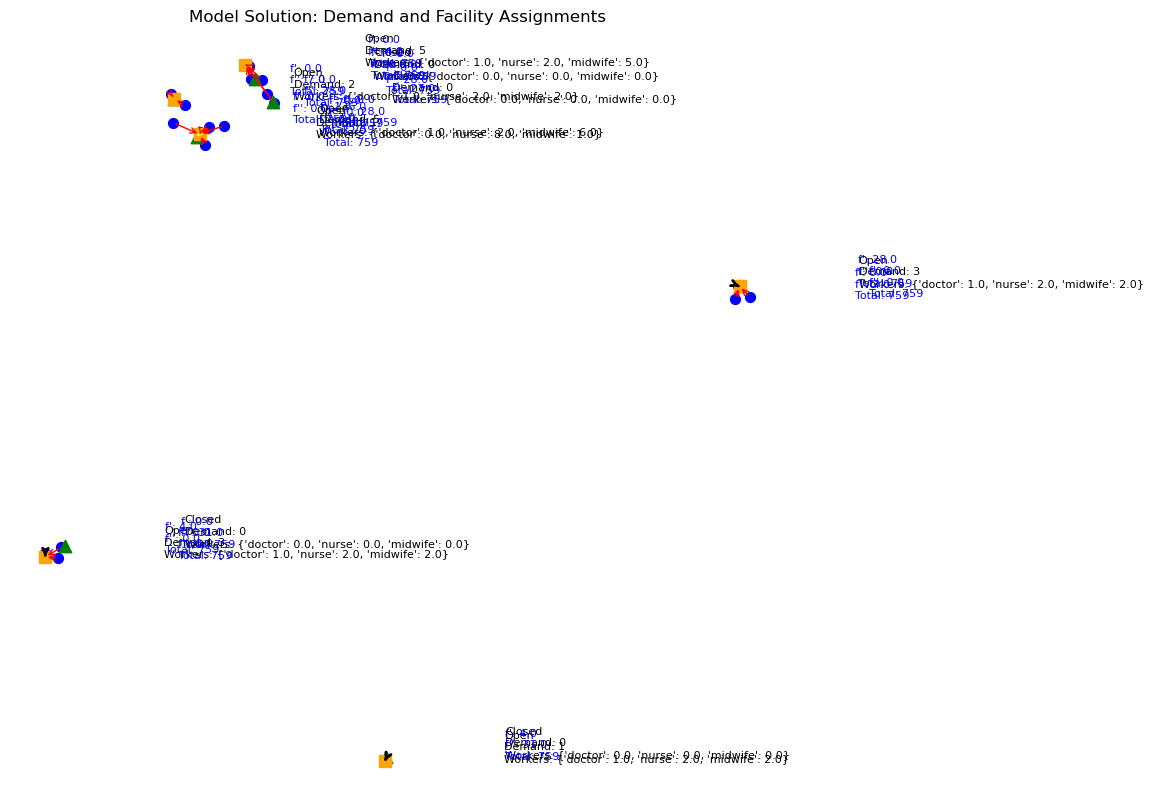

In [51]:
#%% Plot the solution

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString

def plot_solution(model, demand_points_gdf, hfs_gdf):
    """
    Visualise the solution of the Pyomo model without location names and without the surrounding box.
    
    Parameters:
        model: Solved Pyomo model
        demand_points_gdf: GeoDataFrame with demand points (geometry and labels)
        hfs_gdf: GeoDataFrame with potential locations for health posts (HP) and health centres (HC) (geometry and labels)
    """

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot demand points (without names)
    demand_points_gdf.plot(ax=ax, color='blue', markersize=50)

    # Plot HPs (triangles) and HCs (squares) without labels
    hps_gdf = hfs_gdf[hfs_gdf['label'].isin(model.J_HP)]
    hcs_gdf = hfs_gdf[hfs_gdf['label'].isin(model.J_HC)]
    hps_gdf.plot(ax=ax, color='green', marker='^', markersize=80)
    hcs_gdf.plot(ax=ax, color='orange', marker='s', markersize=80)

    # Plot assignments with arrows
    for i in model.I:
        for j in model.J:
            if model.x1[i, j].value > 0 or model.x2[i, j].value > 0:
                # Get coordinates for the demand point and facility
                dp_coords = demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0]
                hf_coords = hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]

                # Determine arrow colour
                if model.x1[i, j].value > 0 and model.x2[i, j].value > 0:
                    arrow_color = 'black'
                    linewidth = 2
                elif model.x1[i, j].value > 0:
                    arrow_color = 'yellow'
                    linewidth = 1
                elif model.x2[i, j].value > 0:
                    arrow_color = 'red'
                    linewidth = 1

                ax.annotate(
                    '', xy=(hf_coords.x, hf_coords.y), xytext=(dp_coords.x, dp_coords.y),
                    arrowprops=dict(arrowstyle='->', color=arrow_color, lw=linewidth),
                    zorder=1
                )

    # Add information text for each facility (demand and workers), without the facility name
    for j in model.J:
        assigned_demand_points = sum(model.x1[i, j].value > 0 or model.x2[i, j].value > 0 for i in model.I)
        workers = {p: model.w[j, p].value for p in model.P}
        status = "Open" if sum(model.y[j, l].value for l in model.L) > 0 else "Closed"
        hf_coords = hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]
        ax.text(
            hf_coords.x + 0.1, hf_coords.y,
            f"{status}\nDemand: {assigned_demand_points}\nWorkers: {workers}",
            fontsize=8, color='black'
        )

    # Add information text for each demand point (flows), without the demand point name
    for i in model.I:
        f1_sum = sum(model.f1[i, j, s].value for j in model.J for s in model.S)
        f2_sum = sum(model.f2[i, j, s].value for j in model.J for s in model.S)
        total_demand = sum(model.d1[i, s] + model.d2[i, s] for s in model.S)
        dp_coords = demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0]
        ax.text(
            dp_coords.x + 0.1, dp_coords.y,
            f"f': {f1_sum}\nf'': {f2_sum}\nTotal: {total_demand}",
            fontsize=8, color='blue'
        )

    # Remove the axes (box) for a cleaner look
    ax.set_axis_off()

    plt.title("Model Solution: Demand and Facility Assignments")
    plt.show()


# # Example usage:
print(results.solver.termination_condition)
plot_solution(model, demand_points_gdf, hfs_gdf)


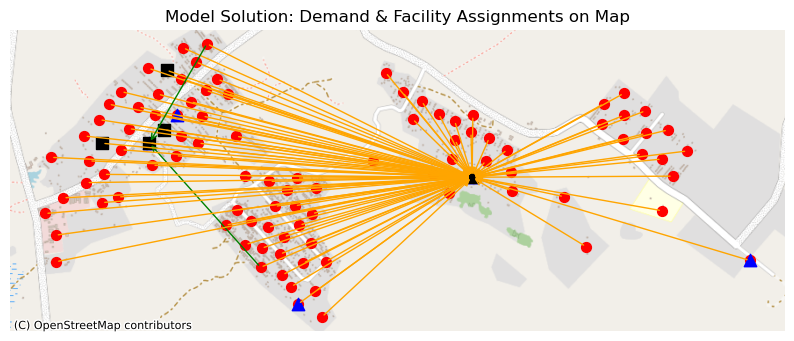

In [16]:
#%% Plot the solution with a map background (only if our demand points and facilities have real-world coordinates; otherwise, use the code in the above cell)

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import contextily as ctx

def plot_solution_with_map(model, demand_points_gdf, hfs_gdf):
    """
    Visualize the solution of the Pyomo model on a real-world map using Contextily

    Parameters:
        model: Solved Pyomo model
        demand_points_gdf: GeoDataFrame with demand points (geometry and labels)
        hfs_gdf: GeoDataFrame with potential locations for health posts (HP) and health centres (HC) (geometry and labels)
        zoom_factor: Proportion of extra space to add around the open facility (default 10%)
        open_facility_label: The label of the open facility to zoom in on. If None, zoom in on all open facilities.
    """

    # Convert to Web Mercator projection for map compatibility
    demand_points_gdf = demand_points_gdf.to_crs(epsg=3857)
    hfs_gdf = hfs_gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot demand points (without names)
    demand_points_gdf.plot(ax=ax, color='red', markersize=50)

    # Plot HPs (blue triangles) and HCs (black squares) without labels
    hps_gdf = hfs_gdf[hfs_gdf['label'].isin(model.J_HP)]
    hcs_gdf = hfs_gdf[hfs_gdf['label'].isin(model.J_HC)]

    hps_gdf.plot(ax=ax, color='blue', marker='^', markersize=80)
    hcs_gdf.plot(ax=ax, color='black', marker='s', markersize=80)

    # Plot assignments with arrows
    for i in model.I:
        for j in model.J:
            if model.x1[i, j].value > 0 or model.x2[i, j].value > 0:
                # Get coordinates for the demand point and facility
                dp_coords = demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0]
                hf_coords = hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]

                # Determine arrow colour and width
                if model.x1[i, j].value > 0 and model.x2[i, j].value > 0:
                    arrow_color = 'black'
                    linewidth = 2
                elif model.x1[i, j].value > 0:
                    arrow_color = 'green'
                    linewidth = 1
                elif model.x2[i, j].value > 0:
                    arrow_color = 'orange'
                    linewidth = 1

                ax.annotate(
                    '', xy=(hf_coords.x, hf_coords.y), xytext=(dp_coords.x, dp_coords.y),
                    arrowprops=dict(arrowstyle='->', color=arrow_color, lw=linewidth),
                    zorder=1
                )

    # # Add information text for each facility (demand and workers), without the facility name
    # for j in model.J:
    #     assigned_demand_points = sum(model.x1[i, j].value > 0 or model.x2[i, j].value > 0 for i in model.I)
    #     workers = {p: model.w[j, p].value for p in model.P}
    #     status = "Open" if sum(model.y[j, l].value for l in model.L) > 0 else "Closed"
    #     hf_coords = hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]
    #     ax.text(
    #         hf_coords.x + 0.1, hf_coords.y,
    #         f"{status}\nDemand: {assigned_demand_points}\nWorkers: {workers}",
    #         fontsize=8, color='black'
    #     )

    # # Add information text for each demand point (flows), without the demand point name
    # for i in model.I:
    #     f1_sum = sum(model.f1[i, j, s].value for j in model.J for s in model.S)
    #     f2_sum = sum(model.f2[i, j, s].value for j in model.J for s in model.S)
    #     total_demand = sum(model.d1[i, s] + model.d2[i, s] for s in model.S)
    #     dp_coords = demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0]
    #     ax.text(
    #         dp_coords.x + 0.1, dp_coords.y,
    #         f"f': {f1_sum}\nf'': {f2_sum}\nTotal: {total_demand}",
    #         fontsize=8, color='blue'
    #     )


    # Add a basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    # Remove the axes (box) for a cleaner look
    ax.set_axis_off()

    plt.title(f"Model Solution: Demand & Facility Assignments on Map")
    plt.show()


# # Example usage:
plot_solution_with_map(model, demand_points_gdf, hfs_gdf)


In [17]:
open_hfs = hfs_gdf[[sum(model.y[j, l].value for l in model.L) > 0 for j in hfs_gdf['label']]]
open_hfs

,index,Name,Camp,type_f,id,geometry,x,y,label
2,41,HP_CandidateLocation4,Tierkidi,HP,hp4,POINT (3817721.663 924509.871),34.295177,8.276083,j3
4,64,HP_CandidateLocation2,Tierkidi,HP,hp2,POINT (3815964.563 924695.922),34.279393,8.277737,j5


In [57]:
open_hfs[open_hfs['label'].isin(['j1'])]

,index,Name,Camp,type_f,id,geometry,x,y,label
0,0,HC_CandidateLocation6,Pinyudo-II,HC,hc6,POINT (34.42754 7.74874),34.42754,7.748744,j1


In [33]:
open_facility = open_hfs[open_hfs['label'] == 'j5']
open_facility

,index,Name,Camp,type_f,id,geometry,x,y,label
4,10,HP_CandidateLocation2,Jewi,HP,hp2,POINT (34.72502 8.14285),34.72502,8.14285,j5


In [113]:
min_x -= buffer_size
min_x


np.float64(3830456.1664053123)

Filtering open facilities: ['j5']
Matching facilities:    index                   Name      Camp type_f   id  \
4     64  HP_CandidateLocation2  Tierkidi     HP  hp2   

                         geometry          x         y label  
4  POINT (3815964.563 924695.922)  34.279393  8.277737    j5  


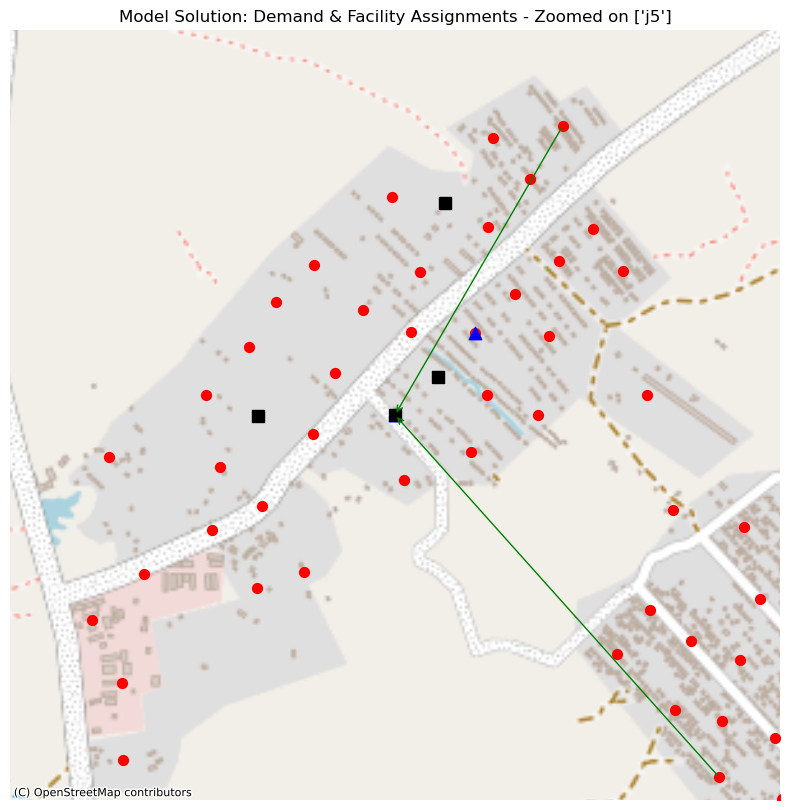

In [22]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import contextily as ctx    

# Convert to Web Mercator projection for map compatibility
demand_points_gdf = demand_points_gdf.to_crs(epsg=3857)
hfs_gdf = hfs_gdf.to_crs(epsg=3857)

# Get open facilities
open_hfs = hfs_gdf[[sum(model.y[j, l].value for l in model.L) > 0 for j in hfs_gdf['label']]]
open_facility_label = 'j5'
zoom_factor = 0.1

if open_facility_label:
    if isinstance(open_facility_label, str):
        open_facility_label = [open_facility_label]  # Ensure it's a list
    open_facility = open_hfs[open_hfs['label'].isin(open_facility_label)]

    # Select the specific open facility (or facilities) to zoom in on
    #open_hfs[open_hfs['label'] == open_facility_label]
else:
    # Zoom in on all open facilities
    open_facility = open_hfs

# Compute zoom-in limits based on the selected facility or all open facilities
if not open_facility.empty:
    print(f"Filtering open facilities: {open_facility_label}")
    print(f"Matching facilities: {open_facility}")  # Should not be empty
    min_x, min_y, max_x, max_y = open_facility.total_bounds  # Bounding box of selected/open facilities

    # If it's a single point, add a small buffer for zooming
    if  len(open_facility) == 1:
        buffer_size = 600  # Define a small buffer size (in meters)
        min_x -= buffer_size
        max_x += buffer_size
        min_y -= buffer_size
        max_y += buffer_size

    x_margin = (max_x - min_x) * zoom_factor
    y_margin = (max_y - min_y) * zoom_factor

else:
    # Default to full view if no open facilities
    min_x, min_y, max_x, max_y = hfs_gdf.total_bounds
    x_margin = (max_x - min_x) * zoom_factor
    y_margin = (max_y - min_y) * zoom_factor
        
# Plot demand points (without names)
fig, ax = plt.subplots(figsize=(10, 10))
demand_points_gdf.plot(ax=ax, color='red', markersize=50)
# Plot HPs (blue triangles) and HCs (black squares) without labels
hps_gdf = hfs_gdf[hfs_gdf['label'].isin(model.J_HP)]
hcs_gdf = hfs_gdf[hfs_gdf['label'].isin(model.J_HC)]
hps_gdf.plot(ax=ax, color='blue', marker='^', markersize=80)
hcs_gdf.plot(ax=ax, color='black', marker='s', markersize=80)

# Plot assignments with arrows
for i in model.I:
    for j in model.J:
        if model.x1[i, j].value > 0 or model.x2[i, j].value > 0:
            # Get coordinates for the demand point and facility
            dp_coords = demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0]
            hf_coords = hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]

            # Determine arrow colour and width
            if model.x1[i, j].value > 0 and model.x2[i, j].value > 0:
                arrow_color = 'black'
                linewidth = 2
            elif model.x1[i, j].value > 0:
                arrow_color = 'green'
                linewidth = 1
            elif model.x2[i, j].value > 0:
                arrow_color = 'orange'
                linewidth = 1

            ax.annotate(
                '', xy=(hf_coords.x, hf_coords.y), xytext=(dp_coords.x, dp_coords.y),
                arrowprops=dict(arrowstyle='->', color=arrow_color, lw=linewidth),
                zorder=1
            )
# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Apply zoom to selected facility or all open facilities
ax.set_xlim(min_x - x_margin, max_x + x_margin)
ax.set_ylim(min_y - y_margin, max_y + y_margin)

# Remove the axes (box) for a cleaner look
ax.set_axis_off()

plt.title(f"Model Solution: Demand & Facility Assignments - Zoomed on {open_facility_label if open_facility_label else 'All Open Facilities'}")
plt.show()



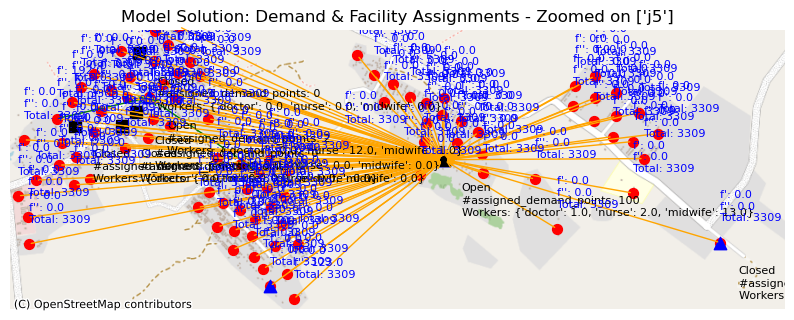

In [11]:
#%% Plot the solution with a map background (only if our demand points and facilities have real-world coordinates; otherwise, use the code in the above cell)

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import contextily as ctx

def plot_solution_with_map(model, demand_points_gdf, hfs_gdf, zoom_factor=0.1, open_facility_label=None):
    """
    Visualize the solution of the Pyomo model on a real-world map using Contextily,
    zooming in around a selected open facility.

    Parameters:
        model: Solved Pyomo model
        demand_points_gdf: GeoDataFrame with demand points (geometry and labels)
        hfs_gdf: GeoDataFrame with potential locations for health posts (HP) and health centres (HC) (geometry and labels)
        zoom_factor: Proportion of extra space to add around the open facility (default 10%)
        open_facility_label: The label of the open facility to zoom in on. If None, zoom in on all open facilities.
    """

    # Convert to Web Mercator projection for map compatibility
    demand_points_gdf = demand_points_gdf.to_crs(epsg=3857)
    hfs_gdf = hfs_gdf.to_crs(epsg=3857)

    # Get open facilities
    open_hfs = hfs_gdf[[sum(model.y[j, l].value for l in model.L) > 0 for j in hfs_gdf['label']]]

    if open_facility_label:
        if isinstance(open_facility_label, str):
            open_facility_label = [open_facility_label]  # Ensure it's a list
        open_facility = open_hfs[open_hfs['label'].isin(open_facility_label)]
    
        # Select the specific open facility (or facilities) to zoom in on
        #open_hfs[open_hfs['label'] == open_facility_label]
    else:
        # Zoom in on all open facilities
        open_facility = open_hfs

    # Compute zoom-in limits based on the selected facility or all open facilities
    if not open_facility.empty:
        min_x, min_y, max_x, max_y = open_facility.total_bounds  # Bounding box of selected/open facilities

        # If it's a single point, add a small buffer for zooming
        if  len(open_facility) == 1:
            buffer_size = 3000  # Define a small buffer size (in meters)
            min_x -= buffer_size
            max_x += buffer_size
            min_y -= buffer_size
            max_y += buffer_size

        x_margin = (max_x - min_x) * zoom_factor
        y_margin = (max_y - min_y) * zoom_factor

    else:
        # Default to full view if no open facilities
        min_x, min_y, max_x, max_y = hfs_gdf.total_bounds
        x_margin = (max_x - min_x) * zoom_factor
        y_margin = (max_y - min_y) * zoom_factor


    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot demand points (without names)
    demand_points_gdf.plot(ax=ax, color='red', markersize=50)

    # Plot HPs (blue triangles) and HCs (black squares) without labels
    hps_gdf = hfs_gdf[hfs_gdf['label'].isin(model.J_HP)]
    hcs_gdf = hfs_gdf[hfs_gdf['label'].isin(model.J_HC)]
    hps_gdf.plot(ax=ax, color='blue', marker='^', markersize=80)
    hcs_gdf.plot(ax=ax, color='black', marker='s', markersize=80)

    # Plot assignments with arrows
    for i in model.I:
        for j in model.J:
            if model.x1[i, j].value > 0 or model.x2[i, j].value > 0:
                # Get coordinates for the demand point and facility
                dp_coords = demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0]
                hf_coords = hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]

                # Determine arrow colour and width
                if model.x1[i, j].value > 0 and model.x2[i, j].value > 0:
                    arrow_color = 'black'
                    linewidth = 2
                elif model.x1[i, j].value > 0:
                    arrow_color = 'green'
                    linewidth = 1
                elif model.x2[i, j].value > 0:
                    arrow_color = 'orange'
                    linewidth = 1

                ax.annotate(
                    '', xy=(hf_coords.x, hf_coords.y), xytext=(dp_coords.x, dp_coords.y),
                    arrowprops=dict(arrowstyle='->', color=arrow_color, lw=linewidth),
                    zorder=1
                )


    # Add information text for each facility (demand and workers), without the facility name
    for j in model.J:
        assigned_demand_points = sum(model.x1[i, j].value > 0 or model.x2[i, j].value > 0 for i in model.I)
        workers = {p: model.w[j, p].value for p in model.P}
        status = "Open" if sum(model.y[j, l].value for l in model.L) > 0 else "Closed"
        hf_coords = hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]
        ax.text(
            hf_coords.x + 100, hf_coords.y - 300,
            f"{status}\n#assigned_demand_points: {assigned_demand_points}\nWorkers: {workers}",
            fontsize=8, color='black',
            clip_on=True  # Ensures text is clipped to the zoomed-in area
        )

    # Add information text for each demand point (flows), without the demand point name
    for i in model.I:
        f1_sum = sum(model.f1[i, j, s].value for j in model.J for s in model.S)
        f2_sum = sum(model.f2[i, j, s].value for j in model.J for s in model.S)
        total_demand = sum(model.d1[i, s] + model.d2[i, s] for s in model.S)
        dp_coords = demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0]
        ax.text(
            dp_coords.x, dp_coords.y + 120,
            f"f': {f1_sum}\nf'': {f2_sum}\nTotal: {total_demand}",
            fontsize=8, color='blue',
            clip_on=True  # Ensures text is clipped
        )

    
    # Add a basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    # Apply zoom to selected facility or all open facilities
    ax.set_xlim(min_x - x_margin, max_x + x_margin)
    ax.set_ylim(min_y - y_margin, max_y + y_margin)

    # Remove the axes (box) for a cleaner look
    ax.set_axis_off()

    plt.title(f"Model Solution: Demand & Facility Assignments - Zoomed on {open_facility_label if open_facility_label else 'All Open Facilities'}")
    plt.show()


# # Example usage:
plot_solution_with_map(model, demand_points_gdf, hfs_gdf, open_facility_label=['j5'])


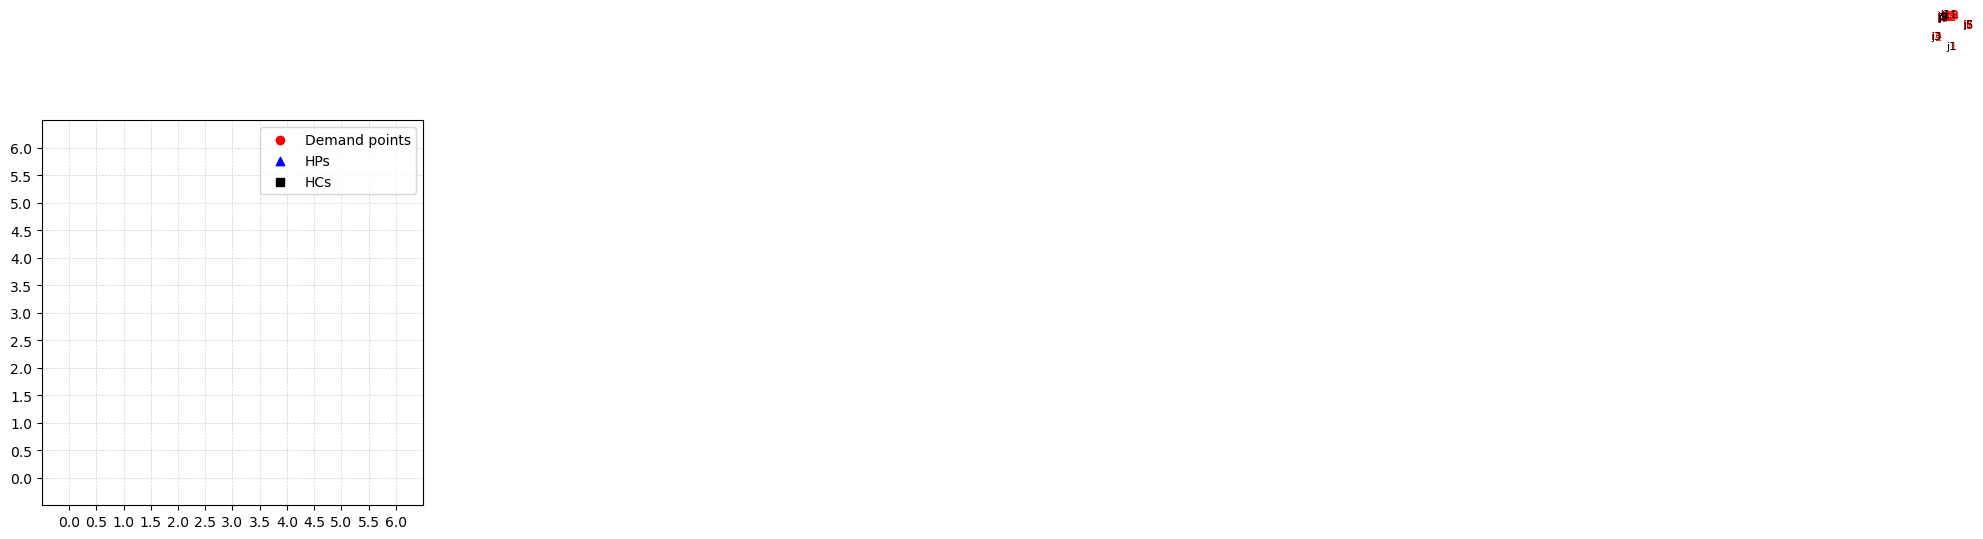

In [37]:
# Plot solution (choosing between first assignment arrows, second assignment arrows, or both)

def plot_solution_v1(model, demand_points_gdf, hfs_gdf, show_first_assignment=False, show_second_assignment=False):
    # Extract open facilities from the model
    open_facilities = {
        j: l
        for (j, l) in model.y.keys()
        if pyo.value(model.y[j, l]) > 0  # Only keep open facilities
    }

    # Open facilities GeoDataFrame
    open_hfs_gdf = hfs_gdf[hfs_gdf['label'].isin(open_facilities.keys())].copy()


    # Add a column for facility type (HP or HC) based on l
    open_hfs_gdf['facility_type'] = open_hfs_gdf['label'].map(open_facilities)


    # Extract first assignments from the model
    assignments1 = {
        (i, j): pyo.value(model.x1[i, j])
        for (i, j) in model.x1.keys()
        if pyo.value(model.x1[i, j]) > 0  # Only keep active first assignments
    }

    # Extract second assignments from the model
    assignments2 = {
        (i, j): pyo.value(model.x2[i, j])
        for (i, j) in model.x2.keys()
        if pyo.value(model.x2[i, j]) > 0  # Only keep active second assignments
    }

    # Create a list of connections (coordinates) for first assignment
    connections1 = [
        (
            demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0],  # Demand point coords
            hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]  # Facility coords
        )
        for (i, j) in assignments1.keys()
    ]

    # Create a list of connections (coordinates) for second assignment
    connections2 = [
        (
            demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0],  # Demand point coords
            hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]  # Facility coords
        )
        for (i, j) in assignments2.keys()
    ]


    fig, ax = plt.subplots(figsize=(5,5))

    # Plot the grid and demand points
    demand_points_gdf.plot(ax=ax, color='red', label='Demand points')

    # Add labels for demand points
    for idx, row in demand_points_gdf.iterrows():
        ax.text(row.geometry.x + 0.05, row.geometry.y + 0.05, row['label'], fontsize=8, color='red')


    # Plot open HPs and HCs separately, only if they are not empty

    hps_open_gdf = open_hfs_gdf[open_hfs_gdf['facility_type'] == 'hp']
    hcs_open_gdf = open_hfs_gdf[open_hfs_gdf['facility_type'] == 'hc']

    if not hps_open_gdf.empty:
        hps_open_gdf.plot(ax=ax, color='blue', marker='^', label='HPs')

    if not hcs_open_gdf.empty:
        hcs_open_gdf.plot(ax=ax, color='black', marker='s', label='HCs')

    # Add labels for open facilities
    for idx, row in open_hfs_gdf.iterrows():
        ax.text(row.geometry.x + 0.05, row.geometry.y + 0.05, row['label'], fontsize=8, color='black')

    
    # Conditionally add first assignment arrows
    if show_first_assignment:
        for (start, end) in connections1:
            ax.annotate(
                '', xy=(end.x, end.y), xytext=(start.x, start.y),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1),
                zorder=1
            )

    # Conditionally add second assignment arrows
    if show_second_assignment:
        for (start, end) in connections2:
            ax.annotate(
                '', xy=(end.x, end.y), xytext=(start.x, start.y),
                arrowprops=dict(arrowstyle='->', color='orange', lw=1),
                zorder=1
            )

    # Set axis limits based on your grid dimensions (6x6)
    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(-0.5, 6.5)

    # Add gridlines at every 0.5 unit
    ax.set_xticks([x * 0.5 for x in range(13)])  # From 0 to 6 with a step of 0.5
    ax.set_yticks([y * 0.5 for y in range(13)])
    ax.grid(color='lightgray', linestyle='--', linewidth=0.5)

    # Add legend and show plot
    ax.legend()
    #plt.title("Location-Allocation Solution with Grid")

    plt.show()

plot_solution_v1(model, demand_points_gdf, hfs_gdf, show_first_assignment=True, show_second_assignment=False)

In [24]:
# Display only the selected variables
print("Selected variables (y_jl = 1, x1_ij = 1, x2_ij = 1, f1_ijs > 0, f2_ijs > 0, w_jp > 0, taumax > 0, deltamax > 0):")
for j in model.J:
        for l in model.L:
            if model.y[j, l].value is not None and model.y[j, l].value > 0:
                print(f"y[{j},{l}] = {model.y[j, l].value}")
for i in model.I:
        for j in model.J:
                if model.x1[i, j].value is not None and model.x1[i, j].value > 0:
                    print(f"x1[{i},{j}] = {model.x1[i, j].value}") 
for i in model.I:
        for j in model.J:
                if model.x2[i, j].value is not None and model.x2[i, j].value > 0:
                    print(f"x2[{i},{j}] = {model.x2[i, j].value}") 
for i in model.I:
        for j in model.J:
            for s in model.S:
                if model.f1[i, j, s].value is not None and model.f1[i, j, s].value > 0:
                    print(f"f1[{i},{j},{s}] = {model.f1[i, j, s].value}") 
for i in model.I:
        for j in model.J:
            for s in model.S:
                if model.f2[i, j, s].value is not None and model.f2[i, j, s].value > 0:
                    print(f"f2[{i},{j},{s}] = {model.f2[i, j, s].value}") 
for j in model.J:
        for p in model.P:
                if model.w[j, p].value is not None and model.w[j, p].value > 0:
                    print(f"w[{j},{p}] = {model.w[j, p].value}") 
for j in model.J:
    if model.taumax[j].value is not None and model.taumax[j].value > 0:
        print(f"taumax[{j}] = {model.taumax[j].value}") 
if model.deltamax.value is not None and model.deltamax.value > 0:
    print(f"deltamax = {model.deltamax.value}") 
    


Selected variables (y_jl = 1, x1_ij = 1, x2_ij = 1, f1_ijs > 0, f2_ijs > 0, w_jp > 0, taumax > 0, deltamax > 0):
y[j3,hc] = 1.0
y[j5,hp] = 1.0
x1[i6,j5] = 1.0
x1[i100,j5] = 1.0
x2[i1,j3] = 1.0
x2[i2,j3] = 1.0
x2[i3,j3] = 1.0
x2[i4,j3] = 1.0
x2[i5,j3] = 1.0
x2[i6,j3] = 1.0
x2[i7,j3] = 1.0
x2[i8,j3] = 1.0
x2[i9,j3] = 1.0
x2[i10,j3] = 1.0
x2[i11,j3] = 1.0
x2[i12,j3] = 1.0
x2[i13,j3] = 1.0
x2[i14,j3] = 1.0
x2[i15,j3] = 1.0
x2[i16,j3] = 1.0
x2[i17,j3] = 1.0
x2[i18,j3] = 1.0
x2[i19,j3] = 1.0
x2[i20,j3] = 1.0
x2[i21,j3] = 1.0
x2[i22,j3] = 1.0
x2[i23,j3] = 1.0
x2[i24,j3] = 1.0
x2[i25,j3] = 1.0
x2[i26,j3] = 1.0
x2[i27,j3] = 1.0
x2[i28,j3] = 1.0
x2[i29,j3] = 1.0
x2[i30,j3] = 1.0
x2[i31,j3] = 1.0
x2[i32,j3] = 1.0
x2[i33,j3] = 1.0
x2[i34,j3] = 1.0
x2[i35,j3] = 1.0
x2[i36,j3] = 1.0
x2[i37,j3] = 1.0
x2[i38,j3] = 1.0
x2[i39,j3] = 1.0
x2[i40,j3] = 1.0
x2[i41,j3] = 1.0
x2[i42,j3] = 1.0
x2[i43,j3] = 1.0
x2[i44,j3] = 1.0
x2[i45,j3] = 1.0
x2[i46,j3] = 1.0
x2[i47,j3] = 1.0
x2[i48,j3] = 1.0
x2[i49,j3] = 1.0

In [25]:
#%% Create Summary table
import pandas as pd

rows = []

# Compute uncovered percentage
covered = {
    (i, j): pyo.value(model.x1[i, j])
    for (i, j) in model.x1.keys()
    if pyo.value(model.x1[i, j]) > 0  # Only keep covered population zones
}

# Compute the total demand for each i by summing over all service types s
demand_covered = {
    i: sum(d1[(i, s)] for s in services)  # Adjust service types as needed
    for i in set(i for i, _ in covered.keys())  # Only for demand points in uncovered
}

total_demand = sum(d1.values())
total_covered_demand = sum(demand_covered.values())
uncovered_percentage = 100 * (1 - (total_covered_demand / total_demand))

# Create HTML snippet for uncovered percentage
uncovered_html = f"<h3>Uncovered Percentage: {uncovered_percentage:.1f}%</h3>"

for j in model.J:
    # Determine if facility j is open by checking if any y[j,l] > 0.
    facility_type = None
    for l in model.L:
        if model.y[j, l].value is not None and model.y[j, l].value > 0:
            facility_type = l
            break  # Only one type is assigned per facility.
    if facility_type is None:
        continue  # Skip facilities that are not open.

    # --- Satisfied Demand: compute f1 and f2 sums per service ---
    f1_sums = {}
    f2_sums = {}
    for s in model.S:
        f1_total = 0
        f2_total = 0
        for i in model.I:
            f1_val = model.f1[i, j, s].value if model.f1[i, j, s].value is not None else 0
            f2_val = model.f2[i, j, s].value if model.f2[i, j, s].value is not None else 0
            f1_total += f1_val
            f2_total += f2_val
        f1_sums[s] = f1_total
        f2_sums[s] = f2_total

    overall_f1 = sum(f1_sums[s] for s in model.S)
    overall_f2 = sum(f2_sums[s] for s in model.S)
    overall_satisfied = overall_f1 + overall_f2

    # --- Total Demand Assigned: compute d1 and d2 sums per service ---
    assigned_demand_d1 = {}
    assigned_demand_d2 = {}
    for s in model.S:
        total_d1 = 0
        total_d2 = 0
        for i in model.I:
            d1_val = model.d1[i, s] if model.d1[i, s] is not None else 0
            d2_val = model.d2[i, s] if model.d2[i, s] is not None else 0
            x1_val = model.x1[i, j].value if model.x1[i, j].value is not None else 0
            x2_val = model.x2[i, j].value if model.x2[i, j].value is not None else 0
            total_d1 += d1_val * x1_val
            total_d2 += d2_val * x2_val
        assigned_demand_d1[s] = total_d1
        assigned_demand_d2[s] = total_d2

    overall_d1 = sum(assigned_demand_d1[s] for s in model.S)
    overall_d2 = sum(assigned_demand_d2[s] for s in model.S)
    overall_assigned = overall_d1 + overall_d2

    # --- Compute capacity per service (number of services available) ---
    capacity_per_service = {}
    for s in model.S:
        available_time = 0
        for p in model.P:
            w_val = model.w[j, p].value if model.w[j, p].value is not None else 0
            available_time += model.h[p] * model.a_W[p, s] * w_val
        service_time = q[s]
        capacity = int(available_time / service_time) if service_time > 0 else 0
        capacity_per_service[s] = capacity

    # --- Compute Efficiency as (overall satisfied)/(overall assigned) ---
    efficiency = overall_satisfied / overall_assigned if overall_assigned > 0 else None

    # --- Compute new Utilization (Service/Personnel) ---
    # Total service time provided = sum_{s in S} ( (f1_s + f2_s) * q[s] )
    total_service_time = sum((f1_sums[s] + f2_sums[s]) * q[s] for s in model.S)
    # Total personnel time = sum_{p in P} (w[j,p] * h[p])
    total_personnel_time = 0
    for p in model.P:
        personnel = model.w[j, p].value if model.w[j, p].value is not None else 0
        total_personnel_time += personnel * model.h[p]
    new_utilization = total_service_time / total_personnel_time if total_personnel_time > 0 else None

    # --- Compute maximum distance from facility j to any assigned demand point ---
    assigned_distances = []
    for i in model.I:
        if ((model.x1[i, j].value is not None and model.x1[i, j].value > 0) or 
            (model.x2[i, j].value is not None and model.x2[i, j].value > 0)):
            assigned_distances.append(model.t[i, j])
    max_distance = round(max(assigned_distances),2) if assigned_distances else 0

    # --- Build the row for facility j ---
    row = {
        "Facility": j,
        "Type": facility_type,
        "Satisfied Demand": f"{int(overall_f1)}, {int(overall_f2)}",
        "Total Demand": f"{int(overall_d1)}, {int(overall_d2)}",
        "Efficiency (%)": f"{efficiency*100:.1f}%" if efficiency is not None else "N/A",
        "Utilization (Service/Personnel)": f"{new_utilization*100:.1f}%" if new_utilization is not None else "N/A",
        "Max Distance": max_distance
    }
    
    # For each service, show satisfied demand as "f1, f2 (Capacity)"
    for s in model.S:
        row[f"Demand_{s}"] = f"{f1_sums[s]}, {f2_sums[s]} ({capacity_per_service[s]})"
    
    # Add personnel columns (as integers)
    for p in model.P:
        personnel = model.w[j, p].value
        personnel_int = int(personnel) if personnel is not None else 0
        row[f"Personnel_{p}"] = personnel_int
    
    rows.append(row)

# Create a DataFrame from the collected rows.
summary_table = pd.DataFrame(rows)

# --- Enhance headers for managerial insight ---
header_mapping = {
    "Facility": "Facility ID",
    "Type": "Facility Type",
    "Satisfied Demand": "Satisfied Demand (f1, f2)",
    "Total Demand": "Total Demand (d1, d2)",
    "Efficiency (%)": "Efficiency (%)",
    "Utilization (Service/Personnel)": "Utilization (Service/Personnel)",
    "Max Distance": "Max Distance"
}
for s in model.S:
    header_mapping[f"Demand_{s}"] = f"Demand - {s.capitalize()} (Capacity)"
for p in model.P:
    header_mapping[f"Personnel_{p}"] = f"Personnel - {p.capitalize()}"

summary_table.rename(columns=header_mapping, inplace=True)

# --- Define a helper function for conditional formatting ---
def highlight_diff(val):
    try:
        # Expecting format like "a,b (cap)" or "number (cap)"
        left, right = val.split('(')
        left = left.strip()
        capacity_val = int(right.split(')')[0].strip())
        if ',' in left:
            parts = left.split(',')
            demand_val = sum(int(x.strip()) for x in parts)
        else:
            demand_val = int(left)
        diff = capacity_val - demand_val
        if diff < 0:
            return 'background-color: salmon'   # Demand exceeds capacity.
        elif diff > 0:
            return 'background-color: lightgreen'  # Spare capacity available.
        else:
            return ''
    except Exception:
        return ''

# --- Apply Pandas styling (to output as HTML) ---
styled_table = summary_table.style.set_table_styles([
    {'selector': 'th',
     'props': [('background-color', '#4F81BD'),
               ('color', 'white'),
               ('font-size', '12pt'),
               ('text-align', 'center'),
               ('padding', '8px')]}
]).set_properties(**{'text-align': 'center', 'font-size': '11pt'})

# Apply conditional formatting on the per-service demand columns.
for col in summary_table.columns:
    if "Demand - " in col:
        styled_table = styled_table.map(highlight_diff, subset=[col])

styled_table = styled_table.set_caption("Facility Summary Table - Managerial Insights")

# Convert the styled table to HTML
table_html = styled_table.to_html()

# --- Combine uncovered percentage HTML with the table HTML ---
html_content = uncovered_html + table_html


# --- Save the styled table as an HTML file (openable in any browser) ---
#html = styled_table.to_html()
with open("facility_summary_with_uncovered_percentage.html", "w") as f:
    f.write(html_content)

print("Summary table with uncovered percentage saved as 'facility_summary_with_uncovered_percentage.html'.")

# Optionally, export the raw table to CSV and Excel.
# summary_table.to_csv("facility_summary_improved.csv", index=False)
# summary_table.to_excel("facility_summary_improved.xlsx", index=False)


Summary table with uncovered percentage saved as 'facility_summary_with_uncovered_percentage.html'.
